<a href="https://colab.research.google.com/github/andres-merino/FormatoBaseProyectos/blob/main/Plantilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Carrera de Ciencia de Datos</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Reto 1 (No supervisado)
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Emilio Andrade &bull; 2025-12-19
            </font></p>
        </td>  
    </tr>
</table>


## <font color="#0030A1"> Título y descripción inicial</font>

Este notebook analiza condiciones de vivienda asociadas al riesgo del vector del Chagas, usando información de materiales de construcción, presencia de animales, condiciones sanitarias y variables del entorno, el objetivo es encontrar patrones ocultos y perfiles de viviendas con características similares que puedan apoyar decisiones de salud pública

**Equipo:** Emilio Andrade

**Objetivos del análisis**
- Identificar agrupamientos de viviendas con condiciones parecidas
- Comparar dos enfoques de clustering (K-Means y DBSCAN) y evaluar su calidad con métricas
- Visualizar los grupos con reducción de dimensiones (PCA) y relacionarlos con el Status entomológico

**Técnicas utilizadas**
- **K-Means:** particiona en k grupos por cercanía a centroides, útil como línea base
- **DBSCAN:** detecta grupos por densidad y separa ruido, útil cuando hay outliers o formas no esféricas
- **PCA:** reduce dimensiones para visualizar en 2D sin perder toda la estructura


Los paquetes necesarios son:

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


---
## <font color='264CC7'> Carga y descripción de datos </font>

En esta parte cargamos la base de viviendas, y verificamos que el archivo se leyó bien, también miramos el tamaño del dataset y una vista rápida de las primeras filas para no trabajar a ciegas



(1000, 138)


,Código,Status entomologico,Estado,Localidad,Altitud,Longitud,Latitud,A2. Cuantos dormitorios tiene la vivienda,A3 Número de personas que duermen en la vivienda,A4. Duermen 3 o mas personas en algun dormitorio,...,J3 Distancia de la casa (metros),J3 Cuántas,J4. Palma Africana,J4 Distancia de la casa (metros),J4 Cuántas,J5. Otro tipo de de palmera o palma,J5 Cuál,J5 Distancia de la casa (metros),J5 Cuántas,E10 Cuántos
0,AB007,Negativa,Examinada,Algarrobillo,0.0,NaN,NaN,1.0,5.0,-1.0,...,0.0,0.0,2.0,0.0,0.0,2.0,NaN,0.0,0.0,2.0
1,AB207,Negativa,Examinada,Algarrobillo,0.0,NaN,NaN,1.0,1.0,-1.0,...,0.0,0.0,2.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0
2,AB208,Negativa,Examinada,Algarrobillo,0.0,NaN,NaN,1.0,5.0,-1.0,...,0.0,0.0,2.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0
3,AB209,Negativa,Examinada,Algarrobillo,0.0,NaN,NaN,1.0,3.0,-1.0,...,0.0,0.0,2.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0
4,AB210,Negativa,Examinada,Algarrobillo,0.0,NaN,NaN,2.0,10.0,-1.0,...,0.0,0.0,2.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0


,grupo,n_columnas,ejemplos
0,agua_saneamiento,16,"A5 Escusado de uso exclusivo del hogar, A5 Esc..."
1,materiales,26,"B1 Losa de hormigón, B1 Asbestos o similares, ..."
2,animales,17,"E1. Gallinas o Palomas u otras aves, E1 Cuánta..."
3,entorno,56,"G1. Leña, G1 Distancia de la casa (metros), G2..."
4,ubicacion,4,"Localidad, Altitud, Longitud, Latitud"
5,entomologia,1,Status entomologico


,0
Longitud,0.092
Latitud,0.092
G4 Distancia de la casa (metros),0.028
I4 Distancia de la casa (metros),0.027
Altitud,0.026
A3 Número de personas que duermen en la vivienda,0.024
A2. Cuantos dormitorios tiene la vivienda,0.023
E9. Tiene un corral,0.023
J1. Existen palmas a una distancia de 30m,0.022
E7. Chanchos o puercos,0.022


,count
Status entomologico,
Negativa,899
Positiva,101


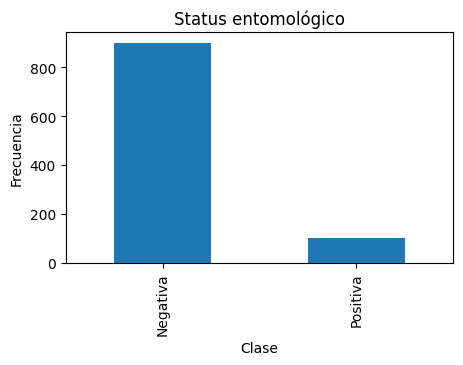

,count
A4. Duermen 3 o mas personas en algun dormitorio,
-1.0,924
0.0,39
1.0,15
NaN,11
2.0,7
5.0,2
6.0,1
8.0,1


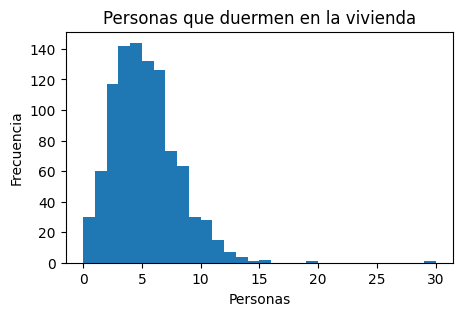

In [18]:
DATA_PATH = "Viviendas_Loja_2005.csv"

df = pd.read_csv(DATA_PATH)
df = df.loc[:, ~df.columns.astype(str).str.contains(r"^Unnamed", regex=True)]

print(df.shape)
display(df.head(5))

def cols_like(pattern):
    return [c for c in df.columns if re.search(pattern, str(c), flags=re.IGNORECASE)]

grupos = {
    "agua_saneamiento": cols_like(r"^A[5-9]\b|^A[5-9]\."),
    "materiales": cols_like(r"^B[1-4]\b|^B[1-4]\."),
    "animales": cols_like(r"^E\d\b|^E\d\."),
    "entorno": cols_like(r"^G\d\b|^G\d\.|^H\d\b|^H\d\.|^I\d\b|^I\d\.|^J\d\b|^J\d\."),
    "ubicacion": [c for c in ["Localidad", "Altitud", "Longitud", "Latitud"] if c in df.columns],
    "entomologia": [c for c in ["Status entomologico"] if c in df.columns],
}

resumen = pd.DataFrame({
    "grupo": list(grupos.keys()),
    "n_columnas": [len(v) for v in grupos.values()],
    "ejemplos": [", ".join(v[:6]) for v in grupos.values()]
})
display(resumen)

vars_base = []
vars_base += grupos["ubicacion"]
vars_base += ["A2. Cuantos dormitorios tiene la vivienda", "A3 Número de personas que duermen en la vivienda", "A4. Duermen 3 o mas personas en algun dormitorio"]
vars_base += ["A5 No tiene", "A6 Medio ambiente", "A7 Rio vertiente acequia o canal", "A8. Hierve o usa cloro en el agua antes de beberla"]
vars_base += ["B1 Paja palma o similares", "B2 Adobe o tapia", "B3 Tierra"]
vars_base += ["E7. Chanchos o puercos", "E9. Tiene un corral"]
vars_base += ["G4. Basura de la vivienda", "G4 Distancia de la casa (metros)", "I4. Maleza o monte", "I4 Distancia de la casa (metros)", "J1. Existen palmas a una distancia de 30m"]
vars_base = [c for c in vars_base if c in df.columns]

na = df[vars_base].isna().mean().sort_values(ascending=False)
display(na.head(15))

if "Status entomologico" in df.columns:
    vc = df["Status entomologico"].value_counts(dropna=False)
    display(vc)
    plt.figure(figsize=(5,3))
    vc.plot(kind="bar")
    plt.title("Status entomológico")
    plt.xlabel("Clase")
    plt.ylabel("Frecuencia")
    plt.show()

if "A4. Duermen 3 o mas personas en algun dormitorio" in df.columns:
    display(df["A4. Duermen 3 o mas personas en algun dormitorio"].value_counts(dropna=False).head(15))

if "A3 Número de personas que duermen en la vivienda" in df.columns:
    x = pd.to_numeric(df["A3 Número de personas que duermen en la vivienda"], errors="coerce").dropna()
    plt.figure(figsize=(5,3))
    plt.hist(x, bins=30)
    plt.title("Personas que duermen en la vivienda")
    plt.xlabel("Personas")
    plt.ylabel("Frecuencia")
    plt.show()

En esta revisión inicial se observa que Longitud y Latitud tienen más valores faltantes que el resto, y que la variable A4 presenta codificación no esperada con valores como -1 y otros fuera del esquema sí no, por eso estos casos se tratarán de forma explícita en el preprocesamiento para no sesgar los agrupamientos


---
## <font color='264CC7'> Preprocesamiento de datos </font>

En esta parte dejamos lista la matriz para clustering, pasamos respuestas a números tratamos faltantes con una imputación simple y estandarizamos, también evitamos usar A4 porque en la base viene con codificación rara y puede sesgar el agrupamiento



In [19]:
target_interpretacion = "Status entomologico"

vars_model = [
    "Altitud",
    "A1. Tiene luz electrica",
    "A2. Cuantos dormitorios tiene la vivienda",
    "A3 Número de personas que duermen en la vivienda",
    "A5 No tiene",
    "A6 Medio ambiente",
    "A7 Rio vertiente acequia o canal",
    "A8. Hierve o usa cloro en el agua antes de beberla",
    "B1 Paja palma o similares",
    "B2 Adobe o tapia",
    "B2 Madera",
    "B3 Tierra",
    "E7. Chanchos o puercos",
    "E9. Tiene un corral",
    "G4. Basura de la vivienda",
    "G4 Distancia de la casa (metros)",
    "I4. Maleza o monte",
    "I4 Distancia de la casa (metros)",
    "J1. Existen palmas a una distancia de 30m",
]

X_raw = df[vars_model].copy()
y_ent = df[target_interpretacion].copy() if target_interpretacion in df.columns else None

def to_binary(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        if x == 1 or x == 1.0:
            return 1.0
        if x == 2 or x == 2.0:
            return 0.0
        if x == 0 or x == 0.0:
            return 0.0
        return np.nan
    s = str(x).strip().upper().replace(",", ".")
    if s in ["VERDADERO", "TRUE", "SI", "SÍ", "1", "1.0"]:
        return 1.0
    if s in ["FALSO", "FALSE", "NO", "0", "0.0", "2", "2.0"]:
        return 0.0
    try:
        v = float(s)
        if v == 1.0:
            return 1.0
        if v == 2.0:
            return 0.0
        if v == 0.0:
            return 0.0
    except:
        pass
    return np.nan

X = X_raw.copy()

bin_cols = [
    "A1. Tiene luz electrica",
    "A5 No tiene",
    "A6 Medio ambiente",
    "A7 Rio vertiente acequia o canal",
    "B1 Paja palma o similares",
    "B2 Adobe o tapia",
    "B2 Madera",
    "B3 Tierra",
    "E7. Chanchos o puercos",
    "E9. Tiene un corral",
    "G4. Basura de la vivienda",
    "I4. Maleza o monte",
    "J1. Existen palmas a una distancia de 30m",
]

for c in bin_cols:
    X[c] = X[c].apply(to_binary)

map_a8 = {1: 2, 2: 1, 3: 0, 1.0: 2, 2.0: 1, 3.0: 0}
X["A8. Hierve o usa cloro en el agua antes de beberla"] = pd.to_numeric(
    X["A8. Hierve o usa cloro en el agua antes de beberla"], errors="coerce"
).map(map_a8)

num_cols = [
    "Altitud",
    "A2. Cuantos dormitorios tiene la vivienda",
    "A3 Número de personas que duermen en la vivienda",
    "G4 Distancia de la casa (metros)",
    "I4 Distancia de la casa (metros)",
]
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")

na_model = X.isna().mean().sort_values(ascending=False)
display(na_model.head(12))

preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

X_ready = preprocess.fit_transform(X)

print("X_ready", X_ready.shape)
print("nan_en_X_ready", int(np.isnan(X_ready).sum()))

display(X[["E7. Chanchos o puercos","E9. Tiene un corral","G4. Basura de la vivienda","I4. Maleza o monte","J1. Existen palmas a una distancia de 30m"]].apply(pd.Series.value_counts).head(6))

,0
A8. Hierve o usa cloro en el agua antes de beberla,0.057
G4 Distancia de la casa (metros),0.028
I4 Distancia de la casa (metros),0.027
Altitud,0.026
J1. Existen palmas a una distancia de 30m,0.025
I4. Maleza o monte,0.024
A3 Número de personas que duermen en la vivienda,0.024
E7. Chanchos o puercos,0.023
A2. Cuantos dormitorios tiene la vivienda,0.023
G4. Basura de la vivienda,0.023


X_ready (1000, 19)
nan_en_X_ready 0


,E7. Chanchos o puercos,E9. Tiene un corral,G4. Basura de la vivienda,I4. Maleza o monte,J1. Existen palmas a una distancia de 30m
0.0,339,769,475,226,952
1.0,638,208,502,750,23


En el preprocesamiento se transformaron variables de la encuesta a un formato numérico para poder aplicar clustering. Las variables tipo sí no se codificaron como 1 y 0, la variable A8 se llevó a una escala ordinal simple donde un valor mayor representa una mejor práctica de tratamiento del agua. Las variables numéricas como altitud, número de dormitorios, número de personas y distancias se convirtieron a tipo numérico

También se manejaron valores faltantes con una imputación mediana, y luego se estandarizaron las variables para que estén en la misma escala y no dominen el agrupamiento solo por magnitud. La variable A4 no se incluyó porque en la base aparece con valores fuera del esquema esperado, esto podría distorsionar los perfiles y por eso se decidió evitarla en esta fase


---
## <font color='264CC7'> Análisis con clustering </font>

En esta parte usamos el subconjunto de 19 variables ya preprocesadas para agrupar viviendas con condiciones parecidas. Se aplican dos algoritmos, K Means y DBSCAN. Para revisar cohesión y separación miramos métricas internas como silhouette, Davies Bouldin y Calinski Harabasz, y también vemos gráficos simples para entender qué tan estables se ven los grupos


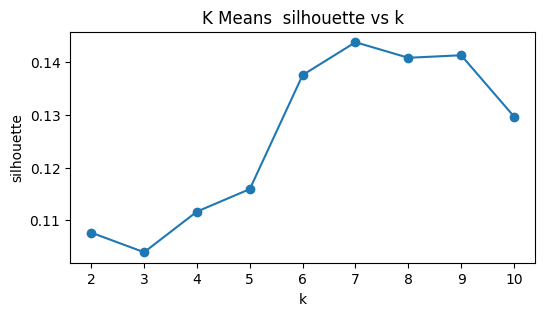

best_k 7
kmeans_silhouette 0.1438
kmeans_davies_bouldin 1.5701
kmeans_calinski_harabasz 89.01


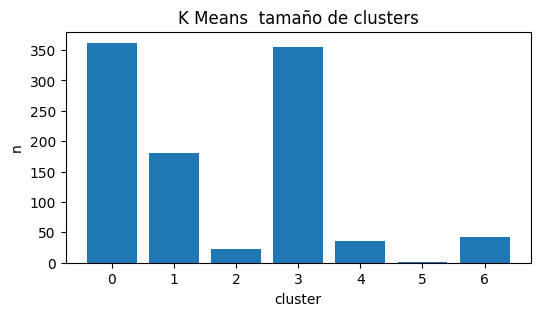

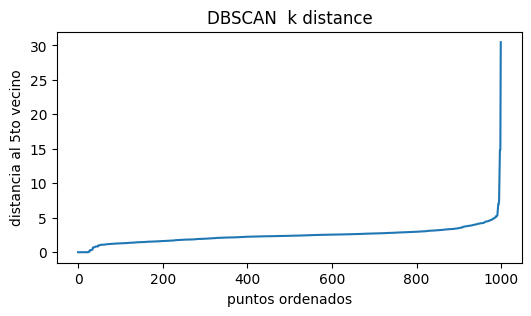

dbscan_eps 4.1482
dbscan_clusters 8
dbscan_ruido 0.023


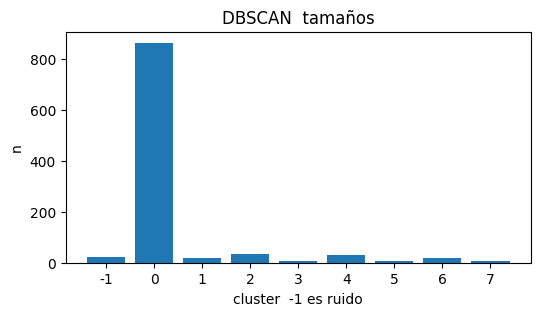

dbscan_silhouette 0.2576
dbscan_davies_bouldin 1.274
dbscan_calinski_harabasz 44.28


In [20]:
ks = range(2, 11)
sil = []
iner = []
RANDOM_STATE = 42

for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    lab = km.fit_predict(X_ready)
    sil.append(silhouette_score(X_ready, lab))
    iner.append(km.inertia_)

plt.figure(figsize=(6,3))
plt.plot(list(ks), sil, marker="o")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.title("K Means  silhouette vs k")
plt.show()

best_k = list(ks)[int(np.argmax(sil))]
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
labels_km = kmeans.fit_predict(X_ready)

print("best_k", best_k)
print("kmeans_silhouette", round(silhouette_score(X_ready, labels_km), 4))
print("kmeans_davies_bouldin", round(davies_bouldin_score(X_ready, labels_km), 4))
print("kmeans_calinski_harabasz", round(calinski_harabasz_score(X_ready, labels_km), 2))

counts_km = pd.Series(labels_km).value_counts().sort_index()
plt.figure(figsize=(6,3))
plt.bar(counts_km.index.astype(str), counts_km.values)
plt.xlabel("cluster")
plt.ylabel("n")
plt.title("K Means  tamaño de clusters")
plt.show()

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_ready)
distances, _ = nn.kneighbors(X_ready)
kdist = np.sort(distances[:, -1])

plt.figure(figsize=(6,3))
plt.plot(kdist)
plt.xlabel("puntos ordenados")
plt.ylabel("distancia al 5to vecino")
plt.title("DBSCAN  k distance")
plt.show()

eps = float(np.percentile(kdist, 95))
min_samples = 5

db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(X_ready)

n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
noise = float(np.mean(labels_db == -1))

print("dbscan_eps", round(eps, 4))
print("dbscan_clusters", n_clusters)
print("dbscan_ruido", round(noise, 4))

counts_db = pd.Series(labels_db).value_counts().sort_index()
plt.figure(figsize=(6,3))
plt.bar(counts_db.index.astype(str), counts_db.values)
plt.xlabel("cluster  -1 es ruido")
plt.ylabel("n")
plt.title("DBSCAN  tamaños")
plt.show()

mask = labels_db != -1
if n_clusters >= 2 and mask.sum() > 0:
    print("dbscan_silhouette", round(silhouette_score(X_ready[mask], labels_db[mask]), 4))
    print("dbscan_davies_bouldin", round(davies_bouldin_score(X_ready[mask], labels_db[mask]), 4))
    print("dbscan_calinski_harabasz", round(calinski_harabasz_score(X_ready[mask], labels_db[mask]), 2))
else:
    print("dbscan_metricas", "no aplica porque hay menos de 2 clusters o casi todo es ruido")

En el clustering se compararon dos enfoques, K Means y DBSCAN usando las 19 variables ya estandarizadas. En K Means se probó k entre 2 y 10 y se eligió k=7 porque la silhouette fue la más alta en ese rango, aun así la separación global es moderada lo que sugiere perfiles que se mezclan en parte, lo cual es esperable en condiciones de vivienda

En DBSCAN se usó el gráfico k distance para guiar eps y se obtuvo eps cercano a 4.15 con min_samples 5, el método encontró 8 grupos y un porcentaje bajo de ruido. Las métricas internas en los puntos no ruido muestran mejor cohesión y separación que K Means, por eso DBSCAN parece captar mejor núcleos de viviendas con condiciones parecidas, aunque genera grupos de tamaños distintos


---
## <font color='264CC7'> Reducción de dimensiones </font>

Ahora reducimos la información a dos componentes principales con PCA, la idea es visualizar en 2D los patrones y ver cómo se acomodan los clusters de K Means y DBSCAN en el mismo espacio


pca_varianza [0.134  0.1006]
pca_varianza_acum 0.2346


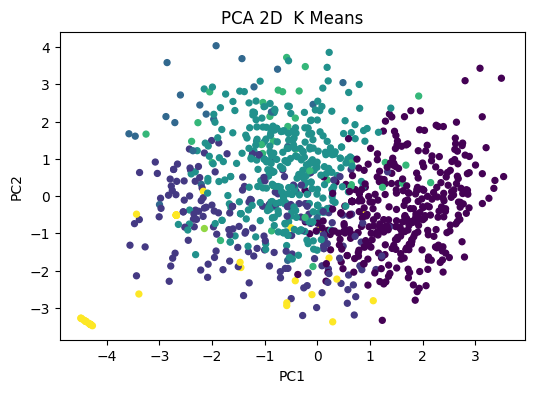

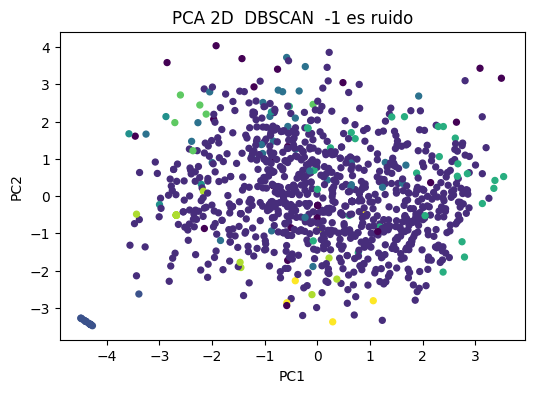

In [21]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(X_ready)

print("pca_varianza", np.round(pca.explained_variance_ratio_, 4))
print("pca_varianza_acum", round(pca.explained_variance_ratio_.sum(), 4))

plt.figure(figsize=(6,4))
plt.scatter(Z[:,0], Z[:,1], c=labels_km, s=18)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D  K Means")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(Z[:,0], Z[:,1], c=labels_db, s=18)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D  DBSCAN  -1 es ruido")
plt.show()


Con PCA se redujo el espacio a dos componentes para visualizar los datos en 2D. La varianza explicada por PC1 y PC2 es cercana a 23 por ciento, por eso el gráfico no separa de forma perfecta todos los perfiles y se observa mezcla entre grupos. Aun así se aprecian tendencias generales, en K Means se distingue una separación parcial a lo largo de PC1, y en DBSCAN se observa un núcleo principal con algunos subgrupos y pocos puntos marcados como ruido


---
## <font color='264CC7'> Interpretación de resultados </font>

En esta parte describimos los perfiles de vivienda que aparecen en los clusters. Para hacerlo de forma clara se comparan promedios y proporciones de las variables por cluster, y de manera adicional se cruza con el status entomológico solo para interpretar riesgo, no para entrenar el modelo


In [22]:
X_interp = X.copy()
X_interp["cluster_km"] = labels_km
X_interp["cluster_db"] = labels_db

perfil_km = X_interp.groupby("cluster_km").mean(numeric_only=True)
display(perfil_km)

if y_ent is not None:
    tabla_km = pd.crosstab(df["Status entomologico"], X_interp["cluster_km"], normalize="columns")
    display(tabla_km)

mask = X_interp["cluster_db"] != -1
perfil_db = X_interp[mask].groupby("cluster_db").mean(numeric_only=True)
display(perfil_db)

if y_ent is not None:
    tabla_db = pd.crosstab(df.loc[mask, "Status entomologico"], X_interp.loc[mask, "cluster_db"], normalize="columns")
    display(tabla_db)
col = "G4 Distancia de la casa (metros)"
s = pd.to_numeric(df[col], errors="coerce")
print("min", s.min(), "max", s.max())
print("n_1000", int((s == 1000).sum()))
print(s.value_counts(dropna=False).head(10))

,Altitud,A1. Tiene luz electrica,A2. Cuantos dormitorios tiene la vivienda,A3 Número de personas que duermen en la vivienda,A5 No tiene,A6 Medio ambiente,A7 Rio vertiente acequia o canal,A8. Hierve o usa cloro en el agua antes de beberla,B1 Paja palma o similares,B2 Adobe o tapia,B2 Madera,B3 Tierra,E7. Chanchos o puercos,E9. Tiene un corral,G4. Basura de la vivienda,G4 Distancia de la casa (metros),I4. Maleza o monte,I4 Distancia de la casa (metros),J1. Existen palmas a una distancia de 30m,cluster_db
cluster_km,,,,,,,,,,,,,,,,,,,,
0,1529.762857,1.0,1.877493,5.353276,0.866097,0.971510,0.484330,0.765714,0.056980,0.843305,0.000000,0.900285,0.683761,0.182336,0.552707,4.242165,0.971429,6.948718,0.0,0.209945
1,1035.561111,1.0,2.060773,4.255556,0.397790,0.552486,0.121547,1.100000,0.005525,0.541436,0.000000,0.447514,0.635359,0.220994,0.458564,5.122222,0.022099,0.128492,0.0,0.022099
2,536.086957,1.0,2.347826,5.173913,0.217391,0.521739,0.130435,1.681818,0.043478,0.347826,0.217391,0.391304,0.652174,0.478261,0.304348,4.521739,0.695652,3.409091,1.0,1.434783
3,1409.997175,1.0,2.222535,4.746479,0.045070,0.335211,0.067606,1.233618,0.025352,0.636620,0.000000,0.397183,0.650704,0.200000,0.523944,3.640227,1.000000,8.250704,0.0,0.095775
4,725.457143,1.0,2.057143,4.685714,0.400000,0.485714,0.142857,0.857143,0.028571,0.342857,1.000000,0.828571,0.742857,0.571429,0.628571,9.411765,0.714286,6.205882,0.0,1.828571
5,2053.000000,1.0,2.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1000.000000,0.000000,0.000000,0.0,-1.000000
6,1319.580645,0.0,0.741935,1.709677,0.186047,0.279070,0.116279,0.785714,0.000000,0.279070,0.000000,0.255814,0.322581,0.064516,0.290323,2.066667,0.322581,2.677419,0.0,3.813953


cluster_km,0,1,2,3,4,5,6
Status entomologico,,,,,,,
Negativa,0.834254,0.906077,0.695652,0.960563,0.942857,1.0,0.976744
Positiva,0.165746,0.093923,0.304348,0.039437,0.057143,0.0,0.023256


,Altitud,A1. Tiene luz electrica,A2. Cuantos dormitorios tiene la vivienda,A3 Número de personas que duermen en la vivienda,A5 No tiene,A6 Medio ambiente,A7 Rio vertiente acequia o canal,A8. Hierve o usa cloro en el agua antes de beberla,B1 Paja palma o similares,B2 Adobe o tapia,B2 Madera,B3 Tierra,E7. Chanchos o puercos,E9. Tiene un corral,G4. Basura de la vivienda,G4 Distancia de la casa (metros),I4. Maleza o monte,I4 Distancia de la casa (metros),J1. Existen palmas a una distancia de 30m,cluster_km
cluster_db,,,,,,,,,,,,,,,,,,,,
0,1323.075472,1.0,2.045828,4.828235,0.433608,0.628672,0.232667,1.023952,0.0,0.698002,0.0,0.600470,0.660400,0.190364,0.537015,4.283019,0.781176,5.972909,0.0,1.406032
1,1122.529412,0.0,0.058824,0.235294,0.000000,0.058824,0.000000,2.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.117647,0.000000,0.000000,0.0,6.000000
2,683.393939,1.0,2.090909,4.666667,0.393939,0.484848,0.121212,0.909091,0.0,0.333333,1.0,0.818182,0.727273,0.606061,0.636364,9.687500,0.727273,6.250000,0.0,4.000000
3,645.600000,1.0,1.800000,4.800000,0.200000,0.800000,0.000000,1.800000,0.0,0.200000,0.0,0.000000,0.600000,0.800000,0.200000,2.400000,0.200000,1.000000,1.0,2.000000
4,1624.800000,1.0,2.166667,5.600000,0.633333,0.700000,0.566667,0.766667,1.0,0.766667,0.0,0.800000,0.633333,0.400000,0.066667,0.366667,0.966667,7.066667,0.0,0.933333
5,771.833333,1.0,3.333333,5.666667,0.166667,0.166667,0.333333,1.600000,0.0,0.333333,0.0,0.000000,0.833333,0.000000,0.166667,5.000000,0.833333,2.666667,1.0,2.000000
6,1448.142857,0.0,1.571429,3.857143,0.105263,0.263158,0.000000,0.500000,0.0,0.315789,0.0,0.263158,0.571429,0.000000,0.714286,7.166667,0.875000,9.857143,0.0,6.000000
7,1609.800000,0.0,1.400000,3.000000,1.000000,1.000000,0.800000,1.000000,0.0,0.800000,0.0,0.800000,1.000000,0.200000,0.600000,2.400000,0.500000,1.600000,0.0,6.000000


cluster_db,0,1,2,3,4,5,6,7
Status entomologico,,,,,,,,
Negativa,0.895592,1.0,0.939394,0.8,0.966667,0.5,1.0,0.8
Positiva,0.104408,0.0,0.060606,0.2,0.033333,0.5,0.0,0.2


min 0.0 max 1000.0
n_1000 1
G4 Distancia de la casa (metros)
0.0     481
10.0    119
5.0      84
2.0      49
3.0      48
20.0     39
15.0     33
NaN      28
4.0      25
6.0      24
Name: count, dtype: int64


En la interpretación se observa que con K Means el cluster 2 presenta la mayor proporción de viviendas positivas y se caracteriza por altitud más baja junto con palmas cercanas, maleza y mayor presencia de animales y corral, este perfil es consistente con condiciones ambientales que pueden favorecer el vector. Otro perfil relevante es el cluster 0, donde destacan condiciones más precarias de saneamiento y materiales como adobe y piso de tierra, además de basura y maleza más frecuentes, su proporción de positividad también es mayor que la de la mayoría de grupos

En DBSCAN aparece un núcleo grande y varios grupos pequeños, por eso se usa para complementar la lectura, algunos subgrupos muestran mayor proporción de positivas pero pueden representar situaciones puntuales. Finalmente se identificó un valor extremo aislado en la distancia a basura, aparece una sola vez y puede explicar un grupo muy pequeño, por lo que se interpreta con cautela


---
## <font color='264CC7'> Conclusión técnica </font>



In [23]:
print("Resumen K Means")
print("k", best_k)
print("silhouette", round(silhouette_score(X_ready, labels_km), 4))
print("davies_bouldin", round(davies_bouldin_score(X_ready, labels_km), 4))
print("calinski_harabasz", round(calinski_harabasz_score(X_ready, labels_km), 2))
print(pd.Series(labels_km).value_counts().sort_index())

print("\nResumen DBSCAN")
print("eps", round(eps, 4))
print("min_samples", min_samples)
n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
noise = float(np.mean(labels_db == -1))
print("clusters", n_clusters)
print("ruido", round(noise, 4))
print(pd.Series(labels_db).value_counts().sort_index())

mask = labels_db != -1
if n_clusters >= 2 and mask.sum() > 0:
    print("\nMetricas DBSCAN sin ruido")
    print("silhouette", round(silhouette_score(X_ready[mask], labels_db[mask]), 4))
    print("davies_bouldin", round(davies_bouldin_score(X_ready[mask], labels_db[mask]), 4))
    print("calinski_harabasz", round(calinski_harabasz_score(X_ready[mask], labels_db[mask]), 2))
else:
    print("\nMetricas DBSCAN", "no aplica")

Resumen K Means
k 7
silhouette 0.1438
davies_bouldin 1.5701
calinski_harabasz 89.01
0    362
1    181
2     23
3    355
4     35
5      1
6     43
Name: count, dtype: int64

Resumen DBSCAN
eps 4.1482
min_samples 5
clusters 8
ruido 0.023
-1     23
 0    862
 1     17
 2     33
 3      5
 4     30
 5      6
 6     19
 7      5
Name: count, dtype: int64

Metricas DBSCAN sin ruido
silhouette 0.2576
davies_bouldin 1.274
calinski_harabasz 44.28


En síntesis el análisis permitió identificar perfiles de vivienda con condiciones parecidas, usando el subconjunto de 19 variables de riesgo ya preprocesadas. Con K Means se obtuvo una partición con k=7, la calidad global es moderada porque la separación no es alta, la silhouette fue 0.1438 y esto sugiere que varios perfiles se mezclan, lo cual es esperable en datos de vivienda y entorno. Aun así se observan grupos con señales claras, por ejemplo el cluster 2 concentra la mayor proporción de viviendas positivas y se relaciona con palmas cercanas maleza y presencia de animales

En DBSCAN se usó eps cercano a 4.1482 con min samples 5, se obtuvieron 8 clusters y un ruido bajo de 0.023. Al evaluar solo los puntos no ruido la silhouette sube a 0.2576 y Davies Bouldin mejora frente a K Means, por eso DBSCAN capta mejor núcleos densos, aunque genera un grupo dominante y varios grupos pequeños que deben interpretarse con cuidado

Como limitación principal, la proyección 2D con PCA explica cerca de 23 por ciento de la variabilidad, entonces la mezcla visual no significa que el modelo esté mal, más bien indica que la estructura es compleja. Además en K Means aparece un cluster de tamaño 1, esto coincide con un valor extremo aislado en una distancia a basura, por lo que ese perfil se interpreta como caso atípico y no como un patrón general

Como mejora, en una siguiente versión se puede ajustar DBSCAN con una búsqueda más sistemática de eps y min samples, y también probar UMAP o t SNE para una visualización más expresiva. Otra mejora es revisar codificaciones especiales en distancias y respuestas, y si se cuenta con más variables del entorno o del hogar, incorporarlas para reforzar la definición de los perfiles de riesgo
